In [73]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import glob
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed 

In [32]:
home = '/global/scratch/users/erin_carroll/SUFHER/'
tif_folder = '/global/scratch/users/erin_carroll/data/tifs/GMUG_/'
tiles = ['12SYH', '13SBC']
gmug = gpd.read_file('/global/scratch/users/erin_carroll/data/spatial_data/gmug').to_crs(32613)

In [3]:
# CFRI - S2
plots = pd.read_csv(home+'validation_data/CFRI/CFRI_plots.csv')
plots = gpd.GeoDataFrame(plots, geometry=gpd.points_from_xy(plots['coordinate_E'], plots['coordinate_N']), crs='EPSG:4326')
plots = plots.to_crs(32613)

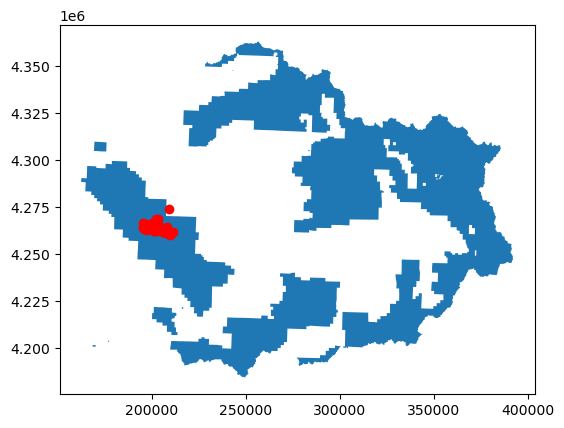

In [4]:
# check that it's in the right spot
fig, ax = plt.subplots()
gmug.plot(ax=ax)
plots.plot(ax=ax, color='red')
plt.show()

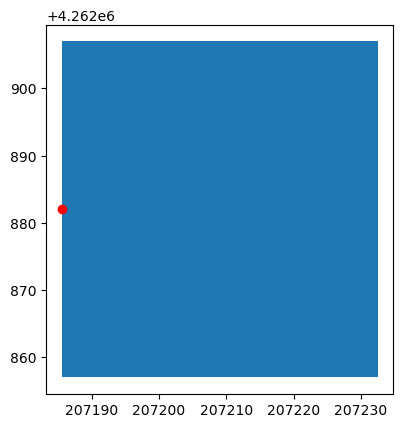

In [20]:
# update plots to be their actual size! squares 82 ft north and south of the point, and then 164 ft east.

# convert to meters
ft_to_m = 0.3048
north_south = 82*ft_to_m
east = 154*ft_to_m

coords = [(point.x, point.y) for point in plots.geometry]

def create_polygon(x, y):
    return Polygon([
        (x, y - north_south),  # Bottom-left
        (x + east, y - north_south),  # Bottom-right
        (x + east, y + north_south),  # Top-right
        (x, y + north_south),  # Top-left
        (x, y - north_south)   # Close polygon (bottom left again)
    ])

# Generate polygons for each point
polygons = [create_polygon(x, y) for x, y in coords]
polygons = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:32613')
polygons['plot'] = plots['Plot_name']

plots_12N = polygons.to_crs(epsg=32612)
plots_13N = polygons.to_crs(epsg=32613)

# visual check
fig, ax = plt.subplots()
gpd.GeoSeries(plots_13N.iloc[1].geometry).plot(ax=ax)
gpd.GeoSeries(plots.iloc[1].geometry).plot(ax=ax, color='red')
plt.show()

In [17]:
bands = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']

In [69]:
# now figure out how to extract data over polygons, not points (will then translate easily to activity polygons... eye roll)

tif_fps = [x for x in sorted(glob.glob(tif_folder+'/*/*/*/*I.tif')) if 'mosaic' not in x and any(t in x for t in tiles)] + [x for x in sorted(glob.glob(home+'LWC_predictions/*.tif')) if any(t in x for t in tiles)]
print(len(tif_fps))
tif_fps[0]

112


'/global/scratch/users/erin_carroll/data/tifs/GMUG_/12SYH/2017/aug/12SYH_2017_aug_NDMI.tif'

In [70]:
def raster_data_to_polygon(fp):
    name = fp.split('/')[-1].strip('.tif')
    if 'lwc' in name:
        t = name.split('_')[-1]
        y = name.split('_')[-2]
        m = 'jul'
        idx = name.split('_')[1]
    else:
        t = name.split('_')[0]
        y = name.split('_')[1]
        m = name.split('_')[2]
        idx = name.split('_')[3]
    
    stats_list = []
    with rasterio.open(fp) as src:
        if src.crs=='EPSG:32612':
            plots_ = plots_12N.copy()
        else: 
            plots_ = plots_13N.copy()
        
        # iterate over each polygon feature in the shapefile
        for index, row in plots_.iterrows():
            geometry = [row.geometry]
            
            try:
                masked_raster, _ = mask(src, geometry, crop=True, filled=True, nodata=np.nan) # Mask the raster with the polygon         
                data = masked_raster[0].flatten() # Convert masked raster to a 1D array and remove NaNs
                data = data[~np.isnan(data)]  # Remove nodata values
                if len(data) > 0:
                    min_val = np.min(data)
                    mean_val = np.mean(data)
                    max_val = np.max(data)
                    std_val = np.std(data)
                else:
                    min_val, mean_val, max_val, std_val = np.nan, np.nan, np.nan, np.nan  # Handle empty geometries
    
            except:
                min_val, mean_val, max_val, std_val = np.nan, np.nan, np.nan, np.nan  # Handle errors gracefully
    
            # Store statistics
            stats_list.append((min_val, mean_val, max_val, std_val, t, y, m, idx))
    
    # Convert statistics list into separate columns
    plots_[['min', 'mean', 'max', 'std', 'tile', 'year', 'month', 'metric']] = stats_list
    return plots_

In [74]:
dfs = Parallel(n_jobs=20)(
    delayed(raster_data_to_polygon)(fp) for fp in tif_fps
)
# started 8:57 - done 1 min later!!

In [80]:
plots_ = pd.concat(dfs, ignore_index=True)
# fsveg_['spectral_index'] = fsveg_['index'] # this wouldn't be encessary if re-ran, fixed
plots_.reset_index()
plots_ = plots_.drop(columns=['geometry'])

In [83]:
# remove polygons that didn't get data
plots_ = plots_[plots_['min'].notna()]
plots_

,plot,min,mean,max,std,tile,year,month,metric
0,RA251,0.08038,0.138434,0.193066,0.031892,12SYH,2017,aug,NDMI
1,RA261,0.001145,0.062559,0.120733,0.029336,12SYH,2017,aug,NDMI
2,RA271,0.015311,0.07077,0.108537,0.025544,12SYH,2017,aug,NDMI
3,RA310,0.001444,0.075864,0.144551,0.043425,12SYH,2017,aug,NDMI
4,RA410,-0.000375,0.089446,0.134412,0.03484,12SYH,2017,aug,NDMI
...,...,...,...,...,...,...,...,...,...
5482,RA610,460228.8125,502389.3375,564311.25,28338.477746,13SBC,2024,jul,lwc
5483,RA1110,549985.5,608856.909375,658241.5,27569.162925,13SBC,2024,jul,lwc
5485,RA2490,221964.984375,239608.33375,271806.40625,14948.276795,13SBC,2024,jul,lwc
5486,RA219,472548.375,523080.78375,553206.375,25489.478183,13SBC,2024,jul,lwc


In [85]:
# summarize across tiles for each year, month, metric, stand ID
plots_ = plots_.groupby(['plot', 'year', 'month', 'metric']).agg({
    'min':'min',
    'mean':'mean',
    'max':'max',
    'std':'max'
}).reset_index()
plots_

,plot,year,month,metric,min,mean,max,std
0,3A,2017,aug,NDMI,0.100269,0.159719,0.237165,0.039781
1,3A,2017,aug,NDVI,0.334049,0.382671,0.446614,0.031675
2,3A,2017,jul,NDMI,0.080198,0.152472,0.235584,0.036602
3,3A,2017,jul,NDVI,0.342598,0.394849,0.452509,0.028170
4,3A,2017,jul,lwc,387695.937500,417468.380952,468528.343750,23107.801878
...,...,...,...,...,...,...,...,...
2739,RA710,2024,jul,NDMI,-0.058894,0.033560,0.082891,0.036368
2740,RA710,2024,jul,NDVI,0.290166,0.363147,0.433598,0.031236
2741,RA710,2024,jul,lwc,382839.781250,446927.122344,528483.625000,34961.274305
2742,RA710,2024,sep,NDMI,-0.112465,-0.010773,0.095533,0.050234


In [86]:
# export
fp_out = home+'validation_data/CFRI/CFRI_plots_spectra_polygons.csv'
plots_.to_csv(fp_out, index=False)